<a href="https://colab.research.google.com/github/S1R3S1D/PINNs/blob/main/2D_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from mpl_toolkits import mplot3d
import math

In [123]:
def fn(x, y):
  return np.sin(x)+np.cos(y)

In [126]:
x = np.linspace(1.0, 5.0, 100)
y = np.linspace(1.0, 5.0, 100)
z = fn(x, y)

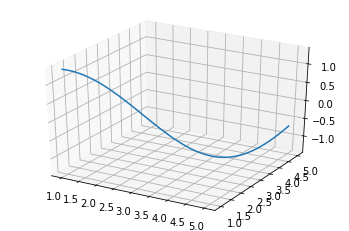

In [127]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(x, y, z)

In [174]:
class NN_model(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(2, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 256)
    self.AC2 = nn.Tanh()
    
    self.FC3 = nn.Linear(256, 1024)
    self.AC4 = nn.Tanh()

    self.FC4 = nn.Linear(1024, 1)
  
  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.AC4(self.FC3(out))
    out = self.FC4(out)
    return out

In [175]:
model_z_data = NN_model()
# model_w_data = model_w_data.double()
lr = 0.001
optimizer_z_data = torch.optim.Adam(model_z_data.parameters(), lr=lr)
epochs = 20000

In [176]:
z_data = torch.tensor(z, dtype=torch.float).view(-1, 1)
# xy_data = torch.tensor(np.column_stack([x, y]), dtype=torch.float)
x_data = torch.tensor(x, dtype=torch.float)
y_data = torch.tensor(y, dtype=torch.float)
print(x.shape)
print(y.shape)
print(x_data.shape)
print(y_data.shape)

print(torch.stack([x_data, y_data], dim=1).shape)
print(y_data[0], x_data[0])
print(torch.stack([x_data, y_data], dim=1)[0])

(100,)
(100,)
torch.Size([100])
torch.Size([100])
torch.Size([100, 2])
tensor(1.) tensor(1.)
tensor([1., 1.])


In [177]:
losses = []
for _ in tqdm(range(epochs)):
  z_preds = model_z_data(torch.stack([x_data, y_data], dim=1))
  
  # x_preds = preds[:, 0]
  # y_preds = preds[:, 1]
  
  loss = torch.mean((z_preds-z_data)**2)

  optimizer_z_data.zero_grad()
  loss.backward()
  optimizer_z_data.step()

100%|██████████| 20000/20000 [03:25<00:00, 97.52it/s] 


In [178]:
with torch.no_grad():
  z_model = model_z_data(torch.stack([x_data, y_data], dim=1))

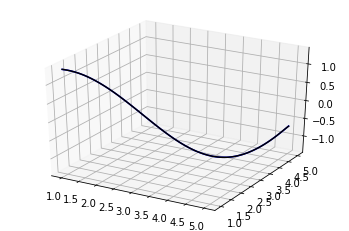

In [179]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(x, y, z, color='blue')
ax.plot3D(x, y, np.array(z_model.squeeze()),color='black')

In [180]:
model_w_de = NN_model()
lr = 0.001
optimizer = torch.optim.Adam(model_w_de.parameters(), lr=lr)
epochs = 20000

In [182]:
x_data_de = torch.tensor(x, dtype=torch.float, requires_grad=True)
y_data_de = torch.tensor(y, dtype=torch.float, requires_grad=True)

for _ in tqdm(range(epochs)):
  z_eqn = model_w_de(torch.stack([x_data_de, y_data_de], dim=1))

  d_f_x = torch.autograd.grad(z_eqn, x_data_de, torch.ones_like(z_eqn), create_graph=True, retain_graph=True)[0]
  d_f_y = torch.autograd.grad(z_eqn, y_data_de, torch.ones_like(z_eqn), create_graph=True, retain_graph=True)[0]

  residual_x = torch.mean((d_f_x-torch.cos(x_data_de))**2)
  residual_y = torch.mean((d_f_y+torch.sin(y_data_de))**2)

  loss = residual_x+residual_y

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


100%|██████████| 20000/20000 [10:11<00:00, 32.70it/s]


In [185]:
with torch.no_grad():
  z_model_de = model_w_de(torch.stack([x_data_de, y_data_de], dim=1))

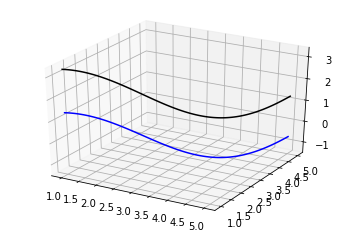

In [186]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(x, y, z, color='blue')
ax.plot3D(x, y, np.array(z_model_de.squeeze()),color='black')